In [ ]:
import os
import io

import numpy as np
import pandas as pd
import scipy.io as sio
from google.cloud import storage


/Users/loso/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.6) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [ ]:
# Configure which .mat object to load (defaults to S001)
mat_object = os.getenv('GCS_OBJECT_MAIN', 'Wearable SSVEP Dataset/S001.mat')
subject_id = os.path.splitext(os.path.basename(mat_object))[0]

client = storage.Client.from_service_account_json(
    os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
)
bucket = client.bucket(os.getenv('GCP_BUCKET_NAME'))

print(f'Loading {mat_object} for subject {subject_id}')
blob = bucket.blob(mat_object)
data_bytes = blob.download_as_bytes()
mat = sio.loadmat(io.BytesIO(data_bytes))

data = mat['data']  # expected shape (channels, time, electrode, block, target)
print('Loaded data shape:', data.shape)

Loading Wearable SSVEP Dataset/S001.mat for subject S001
Loaded data shape: (8, 710, 2, 10, 12)


In [ ]:
# Build epoch-level dataframe for a single subject (one row per electrode x block x target)
expected_shape = (8, 710, 2, 10, 12)
if data.shape != expected_shape:
    raise ValueError(f'Unexpected data shape {data.shape}, expected {expected_shape}')

rows = []
electrode_map = {0: 'wet', 1: 'dry'}

for e_idx in range(data.shape[2]):
    for b_idx in range(data.shape[3]):
        for t_idx in range(data.shape[4]):
            rows.append(
                {
                    'subject': subject_id,
                    'electrode': electrode_map.get(e_idx, str(e_idx)),
                    'block': b_idx + 1,   # 1-based
                    'target': t_idx + 1,  # 1-based
                    'signal': data[:, :, e_idx, b_idx, t_idx],  # shape (8, 710)
                }
            )

all_epochs = pd.DataFrame(rows)
print('DataFrame shape:', all_epochs.shape)
print(all_epochs.head())
print('Electrode counts:')
print(all_epochs['electrode'].value_counts())


DataFrame shape: (240, 5)
  subject electrode  block  target  \
0    S001       wet      1       1   
1    S001       wet      1       2   
2    S001       wet      1       3   
3    S001       wet      1       4   
4    S001       wet      1       5   

                                              signal  
0  [[-52325.52005800724, -53157.22841961553, -554...  
1  [[-56806.91044371786, -58819.819022406286, -60...  
2  [[-58424.81901793594, -57290.15513003797, -551...  
3  [[-59719.47668310861, -61462.01857698074, -609...  
4  [[-57667.36314698238, -60079.16093344456, -608...  
Electrode counts:
electrode
wet    120
dry    120
Name: count, dtype: int64


In [ ]:
# Build full multi-subject epoch DataFrame (102 subjects x 240 epochs)

import re


def load_mat_from_gcs(filepath):
    """Download a .mat from GCS and return the 'data' array."""
    client = storage.Client.from_service_account_json(
        os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
    )
    bucket = client.bucket(os.getenv('GCP_BUCKET_NAME'))
    blob = bucket.blob(filepath)
    bytes_data = blob.download_as_bytes()
    mat = sio.loadmat(io.BytesIO(bytes_data))
    if 'data' not in mat:
        raise KeyError(f"'data' variable missing in {filepath}")
    arr = mat['data']
    if arr.shape != (8, 710, 2, 10, 12):
        raise ValueError(f"Unexpected shape {arr.shape} in {filepath}")
    return arr


def build_subject_df(subject_id, data):
    """Convert one subject's 5-D array into a 240-row DataFrame."""
    expected = (8, 710, 2, 10, 12)
    if data.shape != expected:
        raise ValueError(f"Unexpected shape {data.shape}, expected {expected}")

    rows = []
    for e_idx in range(2):
        for b_idx in range(10):
            for t_idx in range(12):
                rows.append(
                    {
                        'subject': subject_id,
                        'electrode': 'wet' if e_idx == 0 else 'dry',
                        'block': b_idx + 1,
                        'target': t_idx + 1,
                        'signal': data[:, :, e_idx, b_idx, t_idx],
                    }
                )
    return pd.DataFrame(rows)


# List all subject .mat files (skip non-subject files like Impedance.mat)
client = storage.Client.from_service_account_json(
    os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
)
bucket = client.bucket(os.getenv('GCP_BUCKET_NAME'))
prefix = 'Wearable SSVEP Dataset/'
mat_files = []
for b in bucket.list_blobs(prefix=prefix):
    name = b.name
    base = os.path.basename(name)
    if not base.endswith('.mat'):
        continue
    if not re.match(r'S\d+\.mat$', base):
        continue  # skip non-subject files (e.g., Impedance.mat)
    mat_files.append(name)
mat_files.sort()
print(f'Found {len(mat_files)} subject .mat files')

# Build combined DataFrame
all_subject_dfs = []
for fp in mat_files:
    subject_id = os.path.splitext(os.path.basename(fp))[0]
    try:
        data_arr = load_mat_from_gcs(fp)
    except (KeyError, ValueError) as exc:
        print(f'Skipping {fp}: {exc}')
        continue
    df_subj = build_subject_df(subject_id, data_arr)
    all_subject_dfs.append(df_subj)

full_df = pd.concat(all_subject_dfs, ignore_index=True)

# Summaries
print('full_df shape:', full_df.shape)
print(full_df.head())
print('Subject counts:')
print(full_df['subject'].value_counts())
print('Electrode counts:')
print(full_df['electrode'].value_counts())


Found 102 subject .mat files
full_df shape: (24480, 5)
  subject electrode  block  target  \
0    S001       wet      1       1   
1    S001       wet      1       2   
2    S001       wet      1       3   
3    S001       wet      1       4   
4    S001       wet      1       5   

                                              signal  
0  [[-52325.52005800724, -53157.22841961553, -554...  
1  [[-56806.91044371786, -58819.819022406286, -60...  
2  [[-58424.81901793594, -57290.15513003797, -551...  
3  [[-59719.47668310861, -61462.01857698074, -609...  
4  [[-57667.36314698238, -60079.16093344456, -608...  
Subject counts:
subject
S001    240
S065    240
S075    240
S074    240
S073    240
       ... 
S032    240
S031    240
S030    240
S029    240
S102    240
Name: count, Length: 102, dtype: int64
Electrode counts:
electrode
wet    12240
dry    12240
Name: count, dtype: int64


In [ ]:
full_df['signal'][0]

array([[-52325.52005801, -53157.22841962, -55446.94098514, ...,
        -54221.93135154, -55603.44789049, -54680.81263785],
       [-18745.51288757, -18924.99738485, -18735.45460316, ...,
        -18470.40763321, -18182.33836784, -18041.43297919],
       [-21403.26925536, -22218.03499568, -23016.528667  , ...,
        -22420.31827094, -22545.44332894, -21743.68630312],
       ...,
       [ -9890.82514589,  -9916.03791213,  -9598.10671795, ...,
         -9379.10433883,  -9067.5210397 ,  -9066.49285951],
       [-21657.90031301, -21772.43064478, -21580.20565392, ...,
        -21288.96244102, -21014.75125639, -20945.59496317],
       [-18416.8081532 , -18462.49511614, -18162.22179903, ...,
        -17904.81912522, -17616.21341802, -17577.50019893]],
      shape=(8, 710))

In [ ]:
import matplotlib.pyplot as plt

Signal shape: (8, 710)


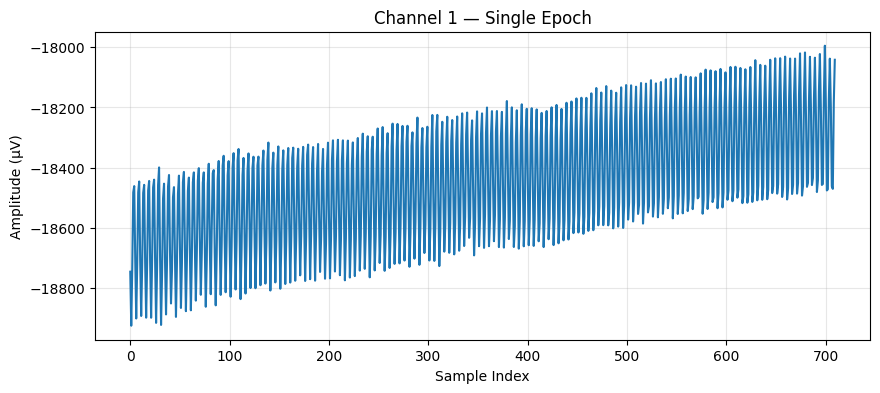

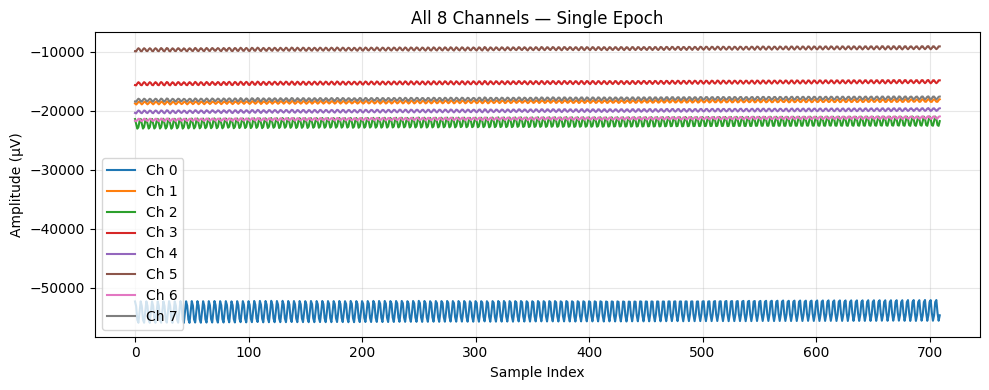

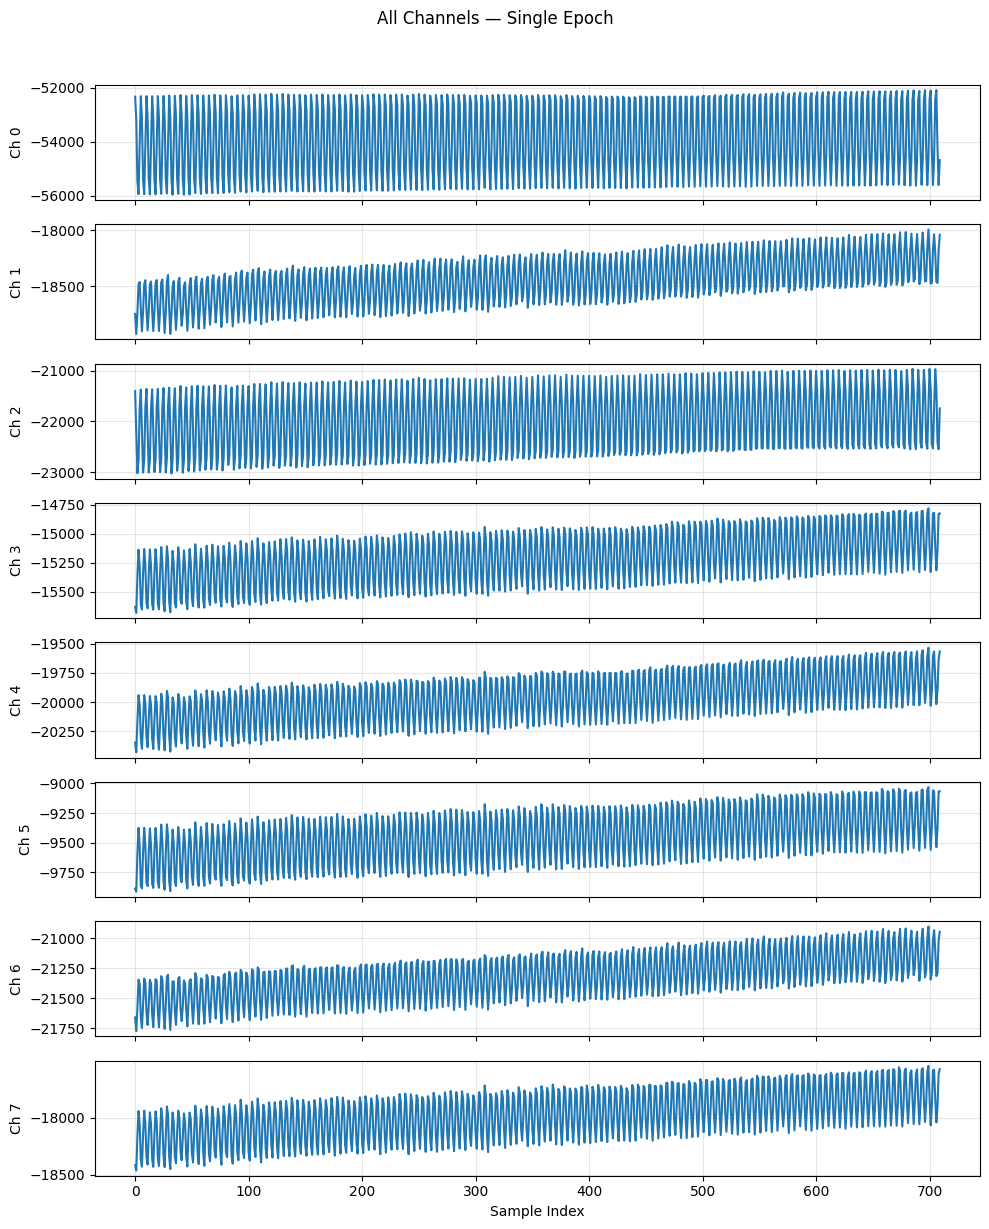

In [ ]:
# Visualize one epoch's signal (channel/time traces)
import matplotlib.pyplot as plt

# Pick one epoch (adjust as needed)
epoch = full_df.iloc[0] if 'full_df' in globals() else all_epochs.iloc[0]
sig = epoch['signal']  # shape (8, 710)

print('Signal shape:', sig.shape)

# Single channel
plt.figure(figsize=(10, 4))
plt.plot(sig[1])
plt.title('Channel 1 — Single Epoch')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (µV)')
plt.grid(alpha=0.3)
plt.show()

# All channels on one plot
plt.figure(figsize=(10, 4))
for ch in range(sig.shape[0]):
    plt.plot(sig[ch], label=f'Ch {ch}')
plt.title('All 8 Channels — Single Epoch')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: subplots per channel
fig, axes = plt.subplots(sig.shape[0], 1, figsize=(10, 12), sharex=True)
for ch in range(sig.shape[0]):
    axes[ch].plot(sig[ch])
    axes[ch].set_ylabel(f'Ch {ch}')
    axes[ch].grid(alpha=0.3)
axes[-1].set_xlabel('Sample Index')
plt.suptitle('All Channels — Single Epoch', y=1.02)
plt.tight_layout()
plt.show()


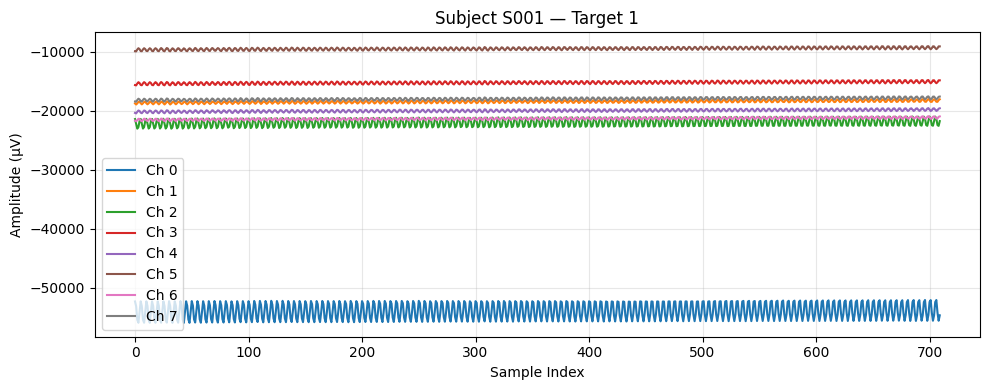

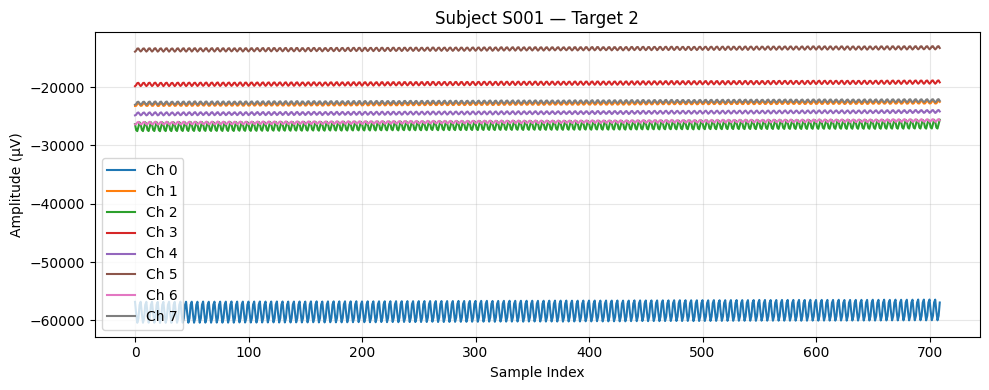

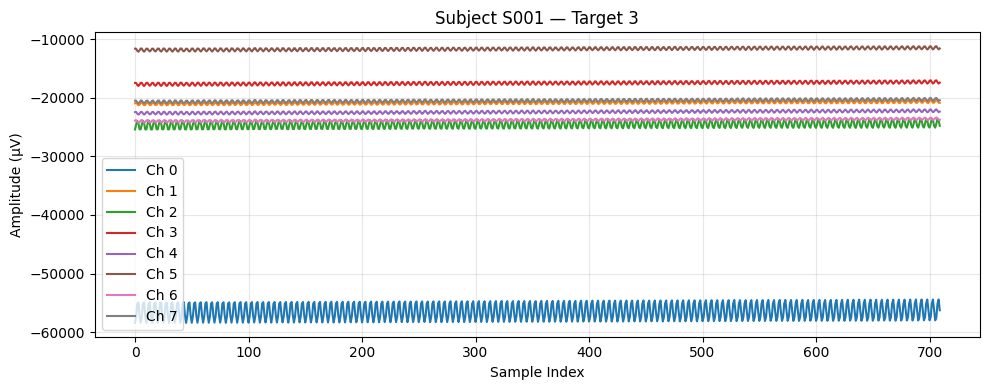

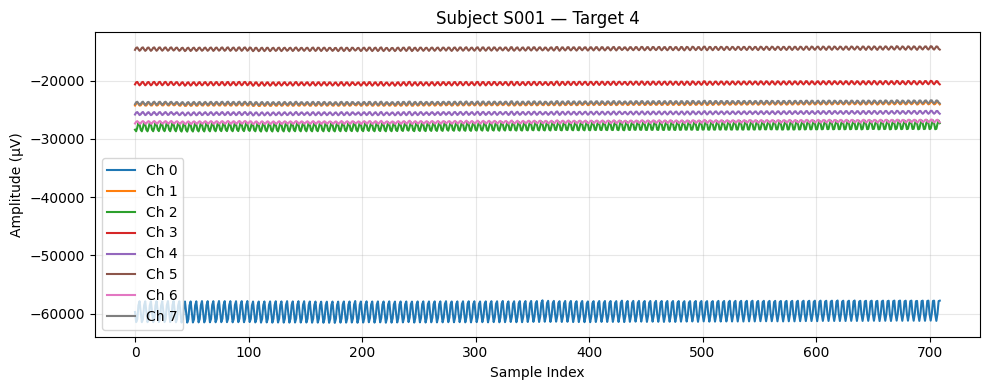

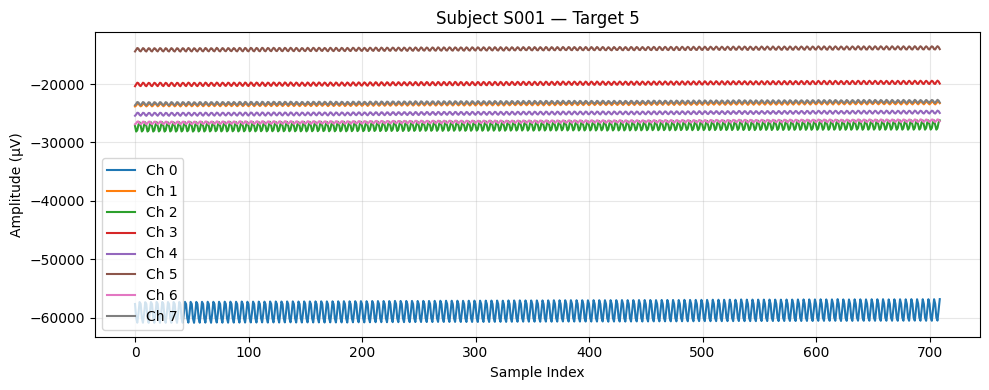

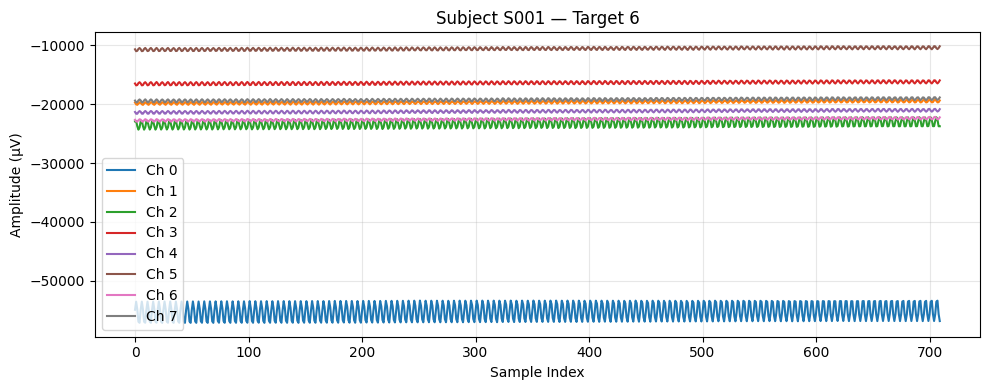

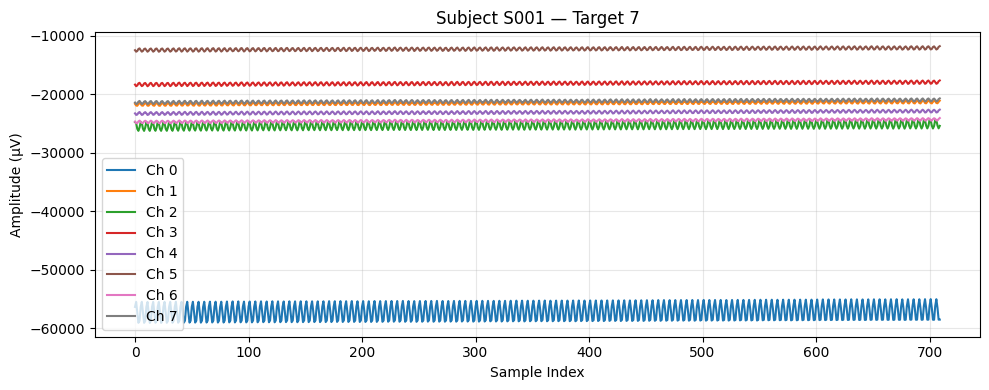

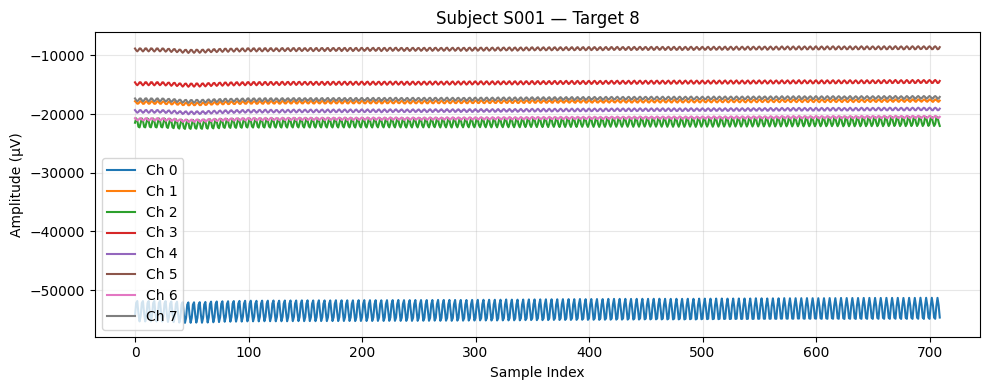

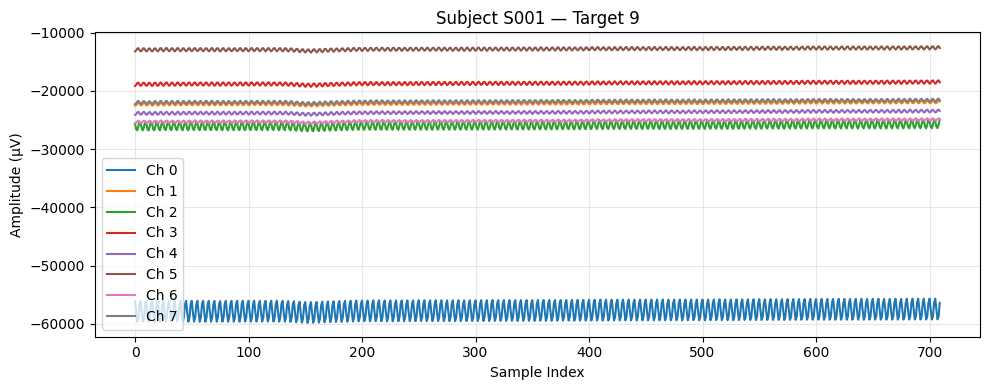

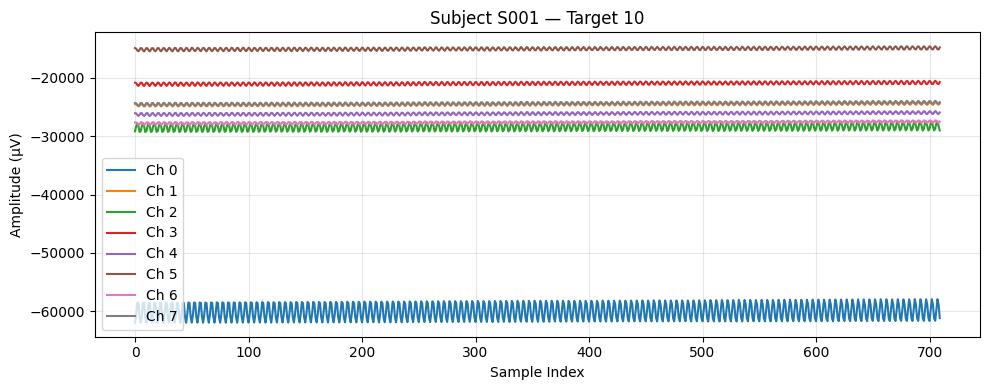

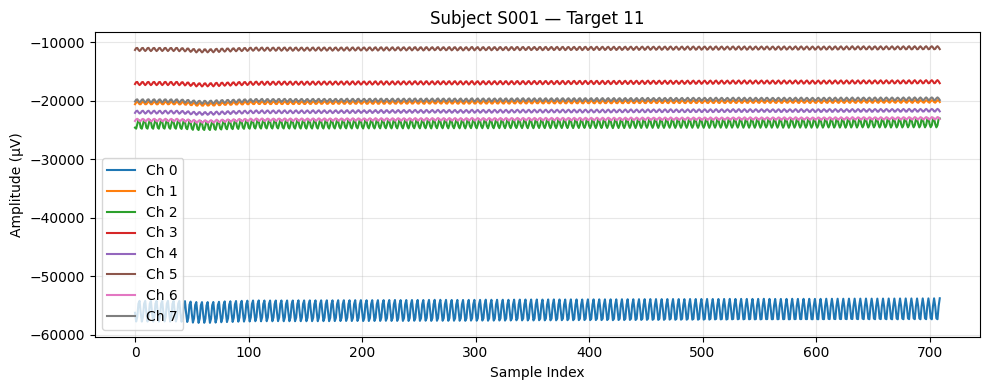

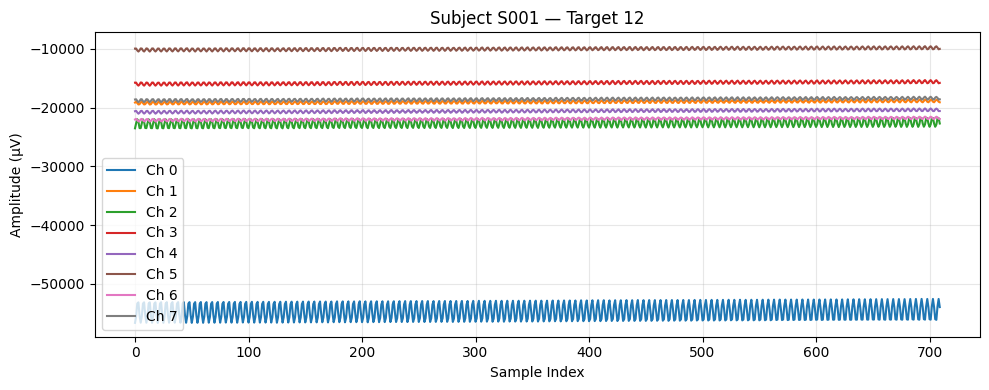

In [ ]:
# Plot per-target overlays for a single subject (wet, block 1)
import matplotlib.pyplot as plt

# Choose subject to visualize
subject_id = 'S001'
subject_df = (full_df if 'full_df' in globals() else all_epochs)
subject_df = subject_df[subject_df['subject'] == subject_id]

if subject_df.empty:
    raise ValueError(f'No rows for subject {subject_id}')

for target_num in range(1, 13):
    subset = subject_df[
        (subject_df['target'] == target_num)
        & (subject_df['electrode'] == 'wet')
        & (subject_df['block'] == 1)
    ]
    if subset.empty:
        print(f'No epoch for target {target_num} (subject {subject_id})')
        continue
    epoch = subset.iloc[0]
    sig = epoch['signal']  # shape (8, 710)

    plt.figure(figsize=(10, 4))
    for ch in range(sig.shape[0]):
        plt.plot(sig[ch], label=f'Ch {ch}')
    plt.title(f'Subject {subject_id} — Target {target_num}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
